# Imports

In [12]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
import thal1

import importlib
import lib

import lib.util
import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est, get_tongue_1d,
                      pl_exist_ld)
from lib.rhs import (rhs_avg_2d, _redu, _redu_moving, 
                     _redu_moving_avg, rhs_avg_1d)



from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

import scipy as sp
from scipy.optimize import root,bisect

from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [13]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier


def intersection(points1, points2, eps):
    tree = spatial.KDTree(points1)
    distances, indices = tree.query(points2, k=1, distance_upper_bound=eps)
    intersection_points = tree.data[indices[np.isfinite(distances)]]
    return intersection_points


def cluster(points, cluster_size):
    dists = dist.pdist(points, metric='sqeuclidean')
    linkage_matrix = hier.linkage(dists, 'average')
    groups = hier.fcluster(linkage_matrix, cluster_size, criterion='distance')
    return np.array([points[cluster].mean(axis=0)
                     for cluster in clusterlists(groups)])


def contour_points(contour, steps=1):
    for linecol in contour.collections:
        
        if len(linecol.get_paths()) == 0:
            return 0
    
    return np.row_stack([path.interpolated(steps).vertices
                         for linecol in contour.collections
                         for path in linecol.get_paths()])

def clusterlists(T):
    '''
    http://stackoverflow.com/a/2913071/190597 (denis)
    T = [2, 1, 1, 1, 2, 2, 2, 2, 2, 1]
    Returns [[0, 4, 5, 6, 7, 8], [1, 2, 3, 9]]
    '''
    groups = collections.defaultdict(list)
    for i, elt in enumerate(T):
        groups[elt].append(i)
    return sorted(groups.values(), key=len, reverse=True)

In [14]:
reload(thal1);reload(nm);reload(rp)
nmc = nm.nmCoupling;rsp = rp.Response

# Definitions

## Forcing function

In [15]:
# def ff(x):
#     return -np.mod(x,2*np.pi)/(2*np.pi) +.5 # works for 1:2

def ff_raw(x,s=1):
    x = np.mod(x,2*np.pi)
    tot = 0
    for i in range(-10,10+1):
        #tot += 1/(np.sqrt(np.pi)*s)*np.exp(-(((x+i*2*np.pi))/s)**2)
        tot += np.exp(-(((x+i*2*np.pi))/s)**2)
    return tot

x_temp,dx_temp = np.linspace(-np.pi,np.pi,1000,retstep=True)
ff_mean = np.sum(ff_raw(x_temp))*dx_temp/(2*np.pi)

def ff(x,s=1):
    x = np.mod(x,2*np.pi)
    tot = 0
    for i in range(-10,10+1):
        #tot += 1/(np.sqrt(np.pi)*s)*np.exp(-(((x+i*2*np.pi))/s)**2)
        tot += np.exp(-(((x+i*2*np.pi))/s)**2)
    return tot - ff_mean


# def ff(x):
#     return np.sin(x)

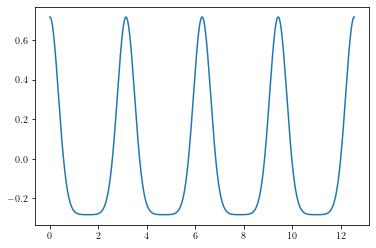

In [16]:
fig,axs = plt.subplots()
t_temp = np.linspace(0,4*np.pi,10000)
axs.plot(t_temp,ff(2*t_temp))

## Dicts

In [17]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [18]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'om':1,'om_fix':1}

In [19]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r'],
        'rhs':thal1.rhs,
        'init':np.array([-.64,0.71,0.25,5]),
        'TN':2000,
        'idx':0,
        'model_name':'thalf0',
        'trunc_order':4,
        'recompute_list':[],
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':True,
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'forcing_fn':ff,
        'save_fig':False}

## RHS full

In [20]:
def _full(t,y,a,eps=0,del1=0):
    pd1 = a.system1.pardict
    omf = a._m[1]
    omx = a._n[1]
    ofix = pd1['om_fix0']

    u = a.system1.forcing_fn(t*(del1+omf))
    
    out1 = thal1.rhs(t,y,pd1,'val',0) + eps*ofix*omx*np.array([u,0,0])
    return np.array(list(out1))

## PL exist reduced

In [21]:
def pl_exist(eps,del1,a,th_init=0,return_data=False):

    system1 = a.system1
    system2 = a.system2
    
    if eps == 0:
        return -1
    # every intersection point must be within eps of a point on the other
    # contour path
    err = 1
    
    # cluster together intersection points so that the original points in each flat
    # cluster have a cophenetic_distance < cluster_size
    cluster_size = 100
    
    th_temp = np.linspace(0, 2*np.pi, 200)
    ps_temp = np.linspace(-.25, .25, 200)
    
    TH,PS = np.meshgrid(th_temp,ps_temp)

    Z1,Z2 = rhs_avg_2d(0,[TH,PS],a,eps,del1)
    # Z1 = 0
    # Z2 = system1.kappa_val*PS
    
    # for i in range(len(a.hz_lam)):
    #     Z1 += eps*PS**i*a.hz_lam[i](TH)*a._n[1]
    #     Z2 += eps*PS**i*a.hi_lam[i](TH)*a._n[1]
    # Z1 -= del1

    #fig,axs = plt.subplots(1,1,figsize=(4,3))
    contour1 = plt.contour(TH,PS,Z1,levels=[0],linewidths=.5,colors='k')
    contour2 = plt.contour(TH,PS,Z2,levels=[0],linewidths=.5,colors='b')
    #print('eps,del',eps,del1)
    #plt.show()

    if return_data:
        return plt

    plt.close()
    
    #contour1 = plt.contour(Z1, colors='k')
    #contour2 = plt.contour(Z2, colors='r')

    #print(intersection_points)

    points1 = contour_points(contour1)
    points2 = contour_points(contour2)
    
    if isinstance(points1, int) or isinstance(points2, int):
        
        return -1
        
    else:
        intersection_points = intersection(points1, points2, err)

        if len(intersection_points) == 0:
            return -1
        else:
            return 1
            print('intersection_points',intersection_points)
            intersection_points = cluster(intersection_points, cluster_size)
            #plt.close()

## Get tongue

In [22]:
def get_tongue_2d(del_list,a,deps=.002,max_eps=.3,min_eps=0):

    ve_exist = np.zeros(len(del_list))
    
    for i in range(len(del_list)):
        print(np.round((i+1)/len(del_list),2),'    ',end='\r')

        if np.isnan(ve_exist[i-1]):
            eps = 0
        else:
            eps = max(ve_exist[i-1] - 2*deps,0)
        while not(pl_exist(eps,del_list[i],a)+1)\
        and eps <= max_eps:
            eps += deps
            #print('existloop',eps)
        if eps >= max_eps:
            ve_exist[i] = np.nan
        else:
            deps2 = deps
            flag = False
            while not(flag) and deps2 < .2:
                #print('while loop',deps2)
                try:
                    out = bisect(pl_exist,0,eps+deps2,args=(del_list[i],a))
                    flag = True
                except ValueError:
                    deps2 += .001
            if flag:
                ve_exist[i] = out
            else:
                ve_exist[i] = np.nan
    print('')
    return del_list,ve_exist

# Load response functions

In [23]:
system1 = rsp(pardict=pd1,**kws1)

* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522512157
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459480753
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [24]:
a11 = nmc(system1,None,
          #recompute_list=recompute_list,
          # recompute_list=['k_thalf0'],
          _n=('om0',1),_m=('om1',1),
          NP=500,NH=500)

* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...
* Loading H thalf0, order=2...
* Loading H thalf0, order=3...
* Loading H thalf0, order=4...


## Tongue

In [19]:
#dtemp = np.linspace(-1,1,51)
d1 = np.linspace(-15,0,10)

del_list_11a,ve_list_11a = get_tongue_2d(2**d1,a11,deps=.01,max_eps=.2)
del_list_11b,ve_list_11b = get_tongue_2d(-2**d1,a11,deps=.01,max_eps=.2)

1.0     
1.0     


In [16]:
d1 = np.linspace(-10,0,50,endpoint=False)
d11a_ld,v11a_ld = get_tongue_ld(2**d1,a11,deps=.001,max_eps=.4)
d11b_ld,v11b_ld = get_tongue_ld(-2**d1,a11,deps=.001,max_eps=.4)

1.0      
1.0      


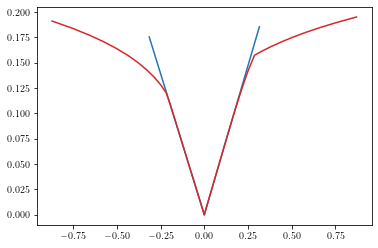

In [25]:
fig,axs = plt.subplots()
axs.plot(del_list_11a,ve_list_11a,color='tab:blue')
axs.plot(del_list_11b,ve_list_11b,color='tab:blue')

axs.plot(d11a_ld,v11a_ld,color='tab:red')
axs.plot(d11b_ld,v11b_ld,color='tab:red')

How do I get the analytic tongue estimate from the reduced equations? Recall from Ermentout 84 for a given system
$$\frac{1}{\omega_X} \frac{dX}{dt} = F(X) + \varepsilon( a G_0(X) + bG_1(X,\omega_f t)),$$
that ssuming $a=0$, if $G_1(X,s) \equiv D\sin(s)$ for some vector $D$ that is the same dimension as $X$,
$$\omega(\varepsilon,a) = \frac{1}{m}\omega_f + \varepsilon a \bar{G}_0 + O(\varepsilon),$$
and if we fix $a$ and $\varepsilon$ at particular values, then $1:m$ phase-locking exists so long as
$$|b| > |a G_0/a_m|,$$
where $a_m$ is the Fourier coefficient of the time-averaged dot product of the $G_1$ with the phase response function (see equations (3.2) and (3.3)).

In the present study, the relationship we seek to understand is between $\delta$, $\varepsilon$, and the natural frequencies $\omega_X$ and $\omega_f$. So $\varepsilon a \bar G_0 \equiv \delta$, and we wish to understand the inequality
$$|\delta| < |\varepsilon \mathcal{H}_1 + \cdots| $$
So get the max of each $\mathcal{H}$ function, multiply them by appropriate powers of $\varepsilon$ to obtain the boundary? How does this work with the averaged $\psi$ equations?

Also, note that the way I set things up, for $\varepsilon,\delta>0$, I want $(\varepsilon \mathcal{H}_1 + \cdots) - \delta> 0$.

Well okay, it turns out that taking the max for each $\mathcal{H}_i$ yields bounds, e.g., $\sum_i \varepsilon^i \mathcal{H}^{(i)}(\theta) \leq \sum_i \varepsilon^i \max_\theta \mathcal{H}^{(i)}(\theta)$, so that the Arnold tongue obtained by varying $\delta$ is not as sharp. So the boundary can't really be obtained, but is it possible to obtain the modified frequency by taking the average values of each $\mathcal{H}$ function?

## Frequency ratio

In [27]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val11 = .05

del_range11 = np.linspace(-.3,.3,10)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

In [28]:
fr_full11 = []
fr_redu11 = []
fr_redu11c = []

for i in range(len(del_range11)):
    
    args11 = [a11,eps_val11,del_range11[i]]

    
    
    solf11 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args11,),**kw_sim)
    #solr11a = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args11,),**kw_sim)
    solr11a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],args=(*args11,),t_eval=t,**kw_sim)
    #solr11_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,1),**kw_sim)

    solr11c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init],t_eval=t,args=(*args11,),**kw_sim)

    timef = t*(a11._m[1]+del_range11[i])
    timer = t*a11._n[1]*(1+del_range11[i])
    
    freq_force = freq_est(t,a11.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf11.y.T[:,0])
    freq_redu = freq_est(t,np.mod(solr11a.y.T[:,0]+timer,2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr11c.y.T[:,0]+timer,2*np.pi))

    print(del_range11[i],freq_full/freq_force,freq_redu/freq_force,freq_reduc/freq_force)

    fr_full11.append(freq_full/freq_force)
    fr_redu11.append(freq_redu/freq_force)
    fr_redu11c.append(freq_reduc/freq_force)

fr_full11 = np.asarray(fr_full11)
fr_redu11 = np.asarray(fr_redu11)
fr_redu11c = np.asarray(fr_redu11c)

-0.3 1.4057666050919606 1.4118330308529945 1.4188428412199818
-0.23333333333333334 1.2769192634560904 1.2823964853153584 1.292247513544109
-0.16666666666666666 1.165141635372009 1.1696985007175602 1.1799446250150476
-0.09999999999999998 1.0443815581137177 1.0551884926097634 1.0568284061011541
-0.033333333333333326 1.0 1.0 1.0
0.033333333333333326 1.000000990427518 1.000000990427518 1.000000990427518
0.10000000000000003 0.9466433338838977 0.9515666561818943 0.9544839526845261
0.16666666666666669 0.8718527596998394 0.8781661232795783 0.8814488214571237
0.23333333333333334 0.8203431556659115 0.8243085706731754 0.827404455312717
0.3 0.7755953447802034 0.7787219775832512 0.7834238142628139


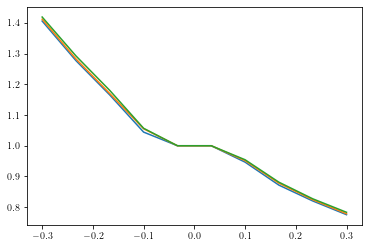

In [29]:
fig,axs = plt.subplots()
axs.plot(del_range11,fr_full11)
axs.plot(del_range11,fr_redu11)
axs.plot(del_range11,fr_redu11c)

In [27]:
# fig,axs = plt.subplots()
# axs.plot(del_range11,fr_full11-1+eps_val11)
# axs.plot(del_range11,fr_redu11-1+eps_val11)
# axs.plot(del_range11,fr_redu11c-1+eps_val11)

# axs.plot(del_list_11a,ve_list_11a,color='tab:blue')
# axs.plot(del_list_11b,ve_list_11b,color='tab:blue')

## Verify

In [23]:
eps11 = .08
del11 = 0.
th_init11 = 3

### Phase plane

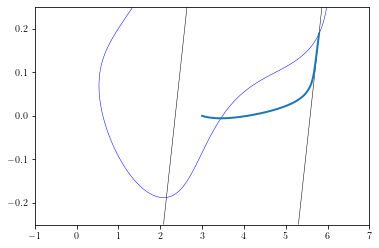

In [313]:
t0 = np.arange(0,1000,.02)

plt = pl_exist(eps11,del11,a11,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t0[0],t0[-1]],[th_init11,0],
                 t_eval=t0,args=(a11,eps11,del11),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

### Integration

In [40]:
dt = .02;T=500
t = np.arange(0,T,dt)

init11 = system1.lc['dat'][int((th_init11/(2*np.pi))*system1.TN),:]
args11 = [a11,eps11,del11]
solf11 = solve_ivp(_full,[0,t[-1]],init11,t_eval=t,args=(*args11,),**kw_sim)

In [51]:
solr11 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init11,0],t_eval=t,args=(*args11,),**kw_sim)
# solr11_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args11,1),**kw_sim)

In [52]:
# solr11b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args11,),**kw_sim)

In [53]:
solr11c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init],t_eval=t,args=(*args11,),**kw_sim)

In [54]:
# fig,axs = plt.subplots(figsize=(15,2))
# axs.plot(t,solf11.y.T[:,0])
# axs.plot(t,a11.system1.forcing_fn(t*(1+del11)))
# axs.set_xlim(t[-1]-100,t[-1])

In [55]:
tp11, phase11 = get_phase(t,solf11.y.T,skipn=10,system1=system1)

(0.0, 6.283185307179586)

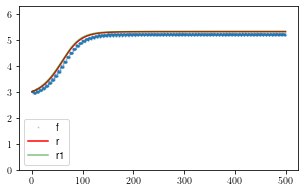

In [57]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase11 = np.mod((a11._m[1]+del11)*np.linspace(0,tp11[-1],len(tp11)),2*np.pi)
y11 = np.mod(phase11-forcing_phase11,2*np.pi)

axs[0].scatter(tp11,y11,s=1,alpha=.25,label='f')
axs[0].plot(solr11.t,np.mod(solr11.y.T[:,0],2*np.pi),color='r',label='r')
# axs[0].plot(solr11b.t,np.mod(solr11b.y.T[:,0]-a11.om*solr11b.y.T[:,2],2*np.pi),color='green',label='r',alpha=.5)
axs[0].plot(solr11c.t,np.mod(solr11c.y.T[:,0],2*np.pi),color='green',label='r1',alpha=.5)

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

In [41]:
freq_full = freq_est(t,solf11.y.T[:,0])

In [44]:
# check to see if natural frequency is obtained by taking averages of higher order \mathcal{H} functions.

omx_temp = 0
for i in range(a11.system1.miter):
    omx_temp += np.mean(eps11**(i+1)*a11.system1.h['dat'][i])
    omx_temp -= del11*a11.om

print(freq_full,omx_temp+1)

1.0000172501632543 1.0141180039306261


# 1:2

In [119]:
a12 = nmc(system1,None,
          recompute_list=['h_data_thalf0'],
          _n=('om0',1),_m=('om1',2),
          NP=500,NH=500)

e1,e2
psi**4*zv0_4(t) + psi**3*zv0_3(t) + psi**2*zv0_2(t) + psi*zv0_1(t) + zv0_0(t)
psi**4*iv0_4(t) + psi**3*iv0_3(t) + psi**2*iv0_2(t) + psi*iv0_1(t) + iv0_0(t)

0 imp0 for z zv0_0(th0)
0 imp0 for i iv0_0(th0)
1 imp0 for z zv0_1(th0)
1 imp0 for i iv0_1(th0)
2 imp0 for z zv0_2(th0)
2 imp0 for i iv0_2(th0)
3 imp0 for z zv0_3(th0)
3 imp0 for i iv0_3(th0)
4 imp0 for z zv0_4(th0)
4 imp0 for i iv0_4(th0)

hz0,hi0,imp
0 uf(t)*zv0_0(t/2 + th0)
1 uf(t)*zv0_1(t/2 + th0)
2 uf(t)*zv0_2(t/2 + th0)
3 uf(t)*zv0_3(t/2 + th0)
4 uf(t)*zv0_4(t/2 + th0)

0 iv0_0(t/2 + th0)*uf(t)
1 iv0_1(t/2 + th0)*uf(t)
2 iv0_2(t/2 + th0)*uf(t)
3 iv0_3(t/2 + th0)*uf(t)
4 iv0_4(t/2 + th0)*uf(t)

* Loading p...
* Computing H thalf0, order=0...
* Loading p...
* Computing H thalf0, order=1...
* Loading p...
* Computing H thalf0, order=2...
* Loading p...
* Computing H thalf0, order=3...
* Loading p...
* Computing H thalf0, order=4...


## Tongue

In [98]:
d1 = np.linspace(-10,-1,10)
del_list_12a,ve_list_12a = get_tongue_2d(2**d1,a12,deps=.01,max_eps=.3)
del_list_12b,ve_list_12b = get_tongue_2d(-2**d1,a12,deps=.01,max_eps=.3)

1.0     
1.0     


In [120]:
d1 = np.linspace(-10,0,50,endpoint=False)
d12a_ld,v12a_ld = get_tongue_ld(2**d1,a12,deps=.01,max_eps=.4)
d12b_ld,v12b_ld = get_tongue_ld(-2**d1,a12,deps=.01,max_eps=.4)

1.0      
1.0      


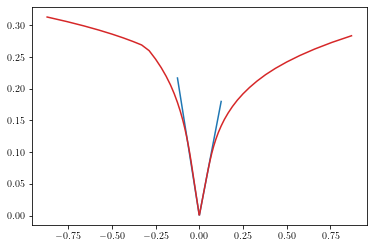

In [121]:
fig,axs = plt.subplots()
axs.plot(del_list_12a,ve_list_12a,color='tab:blue')
axs.plot(del_list_12b,ve_list_12b,color='tab:blue')

axs.plot(d12a_ld,v12a_ld,color='tab:red')
axs.plot(d12b_ld,v12b_ld,color='tab:red')

## Frequency ratio

In [1]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val12 = .05

del_range12 = np.linspace(-.05,.05,10)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

NameError: name 'np' is not defined

In [123]:
fr_full12 = []
fr_redu12 = []
# fr_redu12b = []
fr_redu12c = []

for i in range(len(del_range12)):
    
    args12 = [a12,eps_val12,del_range12[i]]
    
    solf12 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args12,),**kw_sim)
    solr12a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args12,),**kw_sim)
    # solr12b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args12,),**kw_sim)
    #solr12_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args12,1),**kw_sim)
    solr12c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args12,),**kw_sim)

    timef = t*(a12._m[1]+del_range12[i])
    timer = t*a12._n[1]*(1+del_range12[i]/a12._m[1])
    
    freq_force = freq_est(t,a12.system1.forcing_fn(timef))
    freq_full,idxs = freq_est(t,solf12.y.T[:,0],prominence=.25,return_idxs=True)
    freq_redu = freq_est(t,np.mod(solr12a.y.T[:,0]+timer,2*np.pi))
    # freq_redub = freq_est(t,np.mod(solr12b.y.T[:,0],2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr12c.y.T[:,0]+timer,2*np.pi))

    # fig,axs = plt.subplots()
    # axs.plot(t,solf12.y.T[:,0])
    # # axs.plot(t,np.mod(solr12a.y.T[:,0],2*np.pi))
    # # axs.plot(t,12*a12.system2(t*(a12._m[1]+del_range12[i])))
    # axs.scatter(t[idxs],solf12.y.T[idxs,0],s=10)
    # axs.set_xlim(t[-1]-200,t[-1])
    # plt.show()

    print(del_range12[i],freq_full/freq_force,freq_redu/freq_force)

    fr_full12.append(freq_full/freq_force)
    fr_redu12.append(freq_redu/freq_force)
    # fr_redu12b.append(freq_redub/freq_force)
    fr_redu12c.append(freq_reduc/freq_force)

fr_full12 = np.asarray(fr_full12)
fr_redu12 = np.asarray(fr_redu12)
# fr_redu12b = np.asarray(fr_redu12b)
fr_redu12c = np.asarray(fr_redu12c)

-0.05 0.5123571756625316 0.5121200973411973
-0.03888888888888889 0.5093799562309824 0.5091442839789444
-0.02777777777777778 0.5062269109828295 0.5060436982674845
-0.01666666666666667 0.5020336589283975 0.5015038403611441
-0.005555555555555557 0.5 0.5000100452034153
0.005555555555555557 0.5000071788503192 0.49999707769519075
0.016666666666666663 0.49997400162071476 0.49995369027210823
0.027777777777777776 0.4944181730963441 0.4944181730963441
0.03888888888888889 0.49143600894658696 0.49141616937899857
0.05 0.4884807036655975 0.4884609953400174


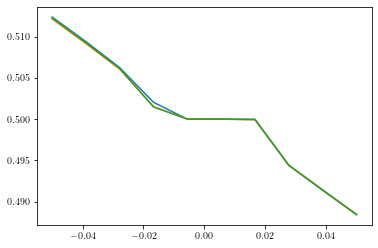

In [126]:
fig,axs = plt.subplots()
axs.plot(del_range12,fr_full12)
axs.plot(del_range12,fr_redu12)
# axs.plot(del_range12,fr_redu12b)
axs.plot(del_range12,fr_redu12c)

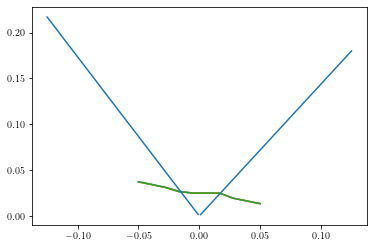

In [125]:
fig,axs = plt.subplots()
axs.plot(del_range12,fr_full12-.5+eps_val12)
axs.plot(del_range12,fr_redu12-.5+eps_val12)
# axs.plot(del_range12,fr_redu12b-.5+eps_val12)
axs.plot(del_range12,fr_redu12c-.5+eps_val12)

axs.plot(del_list_12a,ve_list_12a,color='tab:blue')
axs.plot(del_list_12b,ve_list_12b,color='tab:blue')

* FROM CGL1: Okay when the full freq ratio appears to be shifted relative to the reduced freq, it might be because the om_fix term is messing things up somewhere. So far this is the most plausible explanation for all the shifts. Note that the response requires om_fix to exist in the rhs, but the response functions, when using them in the integration of the reduced models, do not require om_fix. Also, the forcing function needs to be multiplied by both omx and om_fix, but I can do this explicitly for now.

## Verify

In [127]:
eps12 = .05
del12 = 0.04
th_init12 = 3

### Phase plane

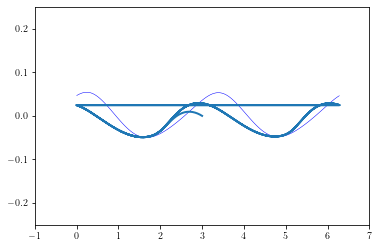

In [128]:
dt12 = .02;T12=2000
t12 = np.arange(0,T12,dt12)

plt = pl_exist(eps12,del12,a12,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t12[0],t12[-1]],[th_init12,0],t_eval=t12,args=(a12,eps12,del12),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

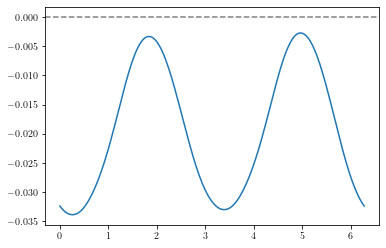

In [129]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = rhs_avg_1d(0,x_temp2,a12,eps12,del12)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

### Integration

In [130]:
init12 = system1.lc['dat'][int((th_init12/(2*np.pi))*system1.TN),:]
args12 = [a12,eps12,del12]
solf12 = solve_ivp(_full,[0,t12[-1]],init12,t_eval=t12,args=(*args12,),**kw_sim)

In [131]:
solr12 = solve_ivp(rhs_avg_2d,[0,t12[-1]],[th_init12,0],t_eval=t12,args=(*args12,),**kw_sim)
# solr12_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args12,1),**kw_sim)

In [132]:
# solr12b = solve_ivp(_redu,[0,t12[-1]],[th_init12,0,0],t_eval=t12,args=(*args12,),**kw_sim)

In [133]:
solr12c = solve_ivp(rhs_avg_1d,[0,t12[-1]],[th_init12,0],t_eval=t12,args=(*args12,),**kw_sim)

In [134]:
tp12, phase12 = get_phase(t12,solf12.y.T,skipn=10,system1=system1)

(0.0, 6.283185307179586)

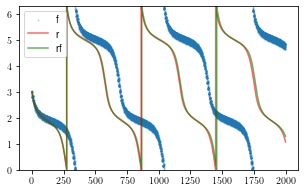

In [135]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase12 = np.mod((a12._m[1]+del12)*np.linspace(0,tp12[-1],len(tp12)),2*np.pi*a12._m[1])
y12 = np.mod(phase12-a12.om*forcing_phase12,2*np.pi)

axs[0].scatter(tp12,y12,s=1,alpha=.25,label='f')
axs[0].plot(solr12.t,np.mod(solr12.y.T[:,0],2*np.pi),color='r',label='r',alpha=.6)
# axs[0].plot(solr12b.t,np.mod(solr12b.y.T[:,0]-a12.om*solr12b.y.T[:,2],2*np.pi),color='green',label='rf',alpha=.6)
axs[0].plot(solr12c.t,np.mod(solr12c.y.T[:,0],2*np.pi),color='green',label='rf',alpha=.6)

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

# 2:3

In [136]:
a23 = nmc(system1,None,
        recompute_list=['p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',2),_m=('om1',3),
        NP=300,NH=300)

e1,e2
psi**4*zv0_4(t) + psi**3*zv0_3(t) + psi**2*zv0_2(t) + psi*zv0_1(t) + zv0_0(t)
psi**4*iv0_4(t) + psi**3*iv0_3(t) + psi**2*iv0_2(t) + psi*iv0_1(t) + iv0_0(t)

0 imp0 for z zv0_0(th0)
0 imp0 for i iv0_0(th0)
1 imp0 for z zv0_1(th0)
1 imp0 for i iv0_1(th0)
2 imp0 for z zv0_2(th0)
2 imp0 for i iv0_2(th0)
3 imp0 for z zv0_3(th0)
3 imp0 for i iv0_3(th0)
4 imp0 for z zv0_4(th0)
4 imp0 for i iv0_4(th0)

hz0,hi0,imp
0 uf(t)*zv0_0(2*t/3 + th0)
1 uf(t)*zv0_1(2*t/3 + th0)
2 uf(t)*zv0_2(2*t/3 + th0)
3 uf(t)*zv0_3(2*t/3 + th0)
4 uf(t)*zv0_4(2*t/3 + th0)

0 iv0_0(2*t/3 + th0)*uf(t)
1 iv0_1(2*t/3 + th0)*uf(t)
2 iv0_2(2*t/3 + th0)*uf(t)
3 iv0_3(2*t/3 + th0)*uf(t)
4 iv0_4(2*t/3 + th0)*uf(t)

* Computing p...
* Computing H thalf0, order=0...
* Computing p...
* Computing H thalf0, order=1...
* Computing p...
* Computing H thalf0, order=2...
* Computing p...
* Computing H thalf0, order=3...
* Computing p...
* Computing H thalf0, order=4...


## Tongue

In [138]:
d1 = np.linspace(-10,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_23a,ve_list_23a = get_tongue_2d(2**d1,a23,deps=.01,max_eps=1)
del_list_23b,ve_list_23b = get_tongue_2d(-2**d1,a23,deps=.01,max_eps=1)

1.0     
1.0     


In [139]:
d1 = np.linspace(-10,0,50,endpoint=False)
d23a_ld,v23a_ld = get_tongue_ld(2**d1,a23,deps=.01,max_eps=.4)
d23b_ld,v23b_ld = get_tongue_ld(-2**d1,a23,deps=.01,max_eps=.4)

1.0      
1.0      


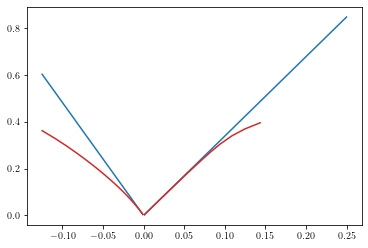

In [150]:
fig,axs = plt.subplots()
axs.plot(del_list_23a,ve_list_23a,color='tab:blue')
axs.plot(del_list_23b,ve_list_23b,color='tab:blue')

axs.plot(d23a_ld,v23a_ld,color='tab:red')
axs.plot(d23b_ld,v23b_ld,color='tab:red')

In [142]:
ve_list_23b

array([0.00470925, 0.0094185 , 0.01883701, 0.03767401, 0.07534802, 0.15069605, 0.3013921 , 0.60278419,        nan,        nan])

## Frequency ratio

In [143]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val23 = .025

del_range23 = np.linspace(-.01,.01,10)

th_init23 = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init23/(2*np.pi))*system1.TN),:]

fr_full23 = []
fr_redu23 = []
fr_redu23c = []

for i in range(len(del_range23)):
    
    args23 = [a23,eps_val23,del_range23[i]]
    
    solf23 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args23,),**kw_sim)
    #solr23b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args23,),**kw_sim)
    solr23a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init23,0],t_eval=t,args=(*args23,),**kw_sim)
    #solr23_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args23,1),**kw_sim)
    solr23c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init23,0],t_eval=t,args=(*args23,),**kw_sim)

    timef = t*(a23._m[1]+del_range23[i])
    timer = t*a23._n[1]*(1+del_range23[i]/a23._m[1])
    # get peaks and calculate freq. in full and redu.
    freq_force = freq_est(t,a23.system1.forcing_fn(timef))
    freq_full,idxs = freq_est(t,solf23.y.T[:,0],prominence=.3,return_idxs=True,width=20)
    freq_redu = freq_est(t,np.mod(solr23a.y.T[:,0]+timer,2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr23c.y.T[:,0]+timer,2*np.pi))

    print(del_range23[i],freq_full/freq_force,freq_redu/freq_force,freq_reduc/freq_force)

    # fig,axs = plt.subplots()
    # axs.plot(t,solf23.y.T[:,0])
    # axs.plot(t,np.mod(solr23a.y.T[:,0]+timer,2*np.pi))
    # axs.plot(t,a23.system2(timef))
    # axs.set_xlim(t[-1]-50,t[-1])
    # axs.scatter(t[idxs],solf23.y.T[idxs,0])
    # plt.show()

    fr_full23.append(freq_full/freq_force)
    fr_redu23.append(freq_redu/freq_force)
    fr_redu23c.append(freq_reduc/freq_force)

fr_full23 = np.asarray(fr_full23)
fr_redu23 = np.asarray(fr_redu23)
fr_redu23c = np.asarray(fr_redu23c)

-0.01 0.6693141958634036 0.6688153415385856 0.6686537106031619
-0.0077777777777777776 0.6687764988879705 0.6679820675955007 0.6679013836883144
-0.005555555555555556 0.6682253979131813 0.6674719979598273 0.6675929654987246
-0.003333333333333334 0.6679301584741322 0.6667605917278858 0.6667069170238885
-0.0011111111111111113 0.6666865803799267 0.6666731540063412 0.6666731540063412
0.0011111111111111113 0.6666618117449925 0.6666618117449925 0.6666618117449925
0.0033333333333333322 0.6667148369780238 0.6666747507083642 0.6666747507083642
0.005555555555555555 0.6667004333825957 0.6666736894123849 0.6666603182318677
0.0077777777777777776 0.6658440414435325 0.6653105446252775 0.6653105446252775
0.01 0.6653218918967179 0.6652152142373766 0.6652152142373766


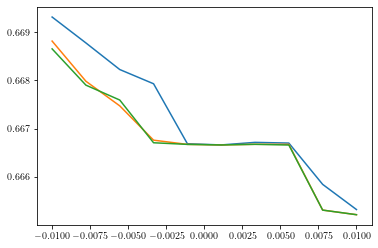

In [147]:
fig,axs = plt.subplots()
axs.plot(del_range23,fr_full23)
axs.plot(del_range23,fr_redu23)
axs.plot(del_range23,fr_redu23c)

(-0.02, 0.02)

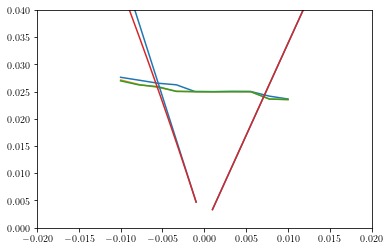

In [151]:
fig,axs = plt.subplots()
axs.plot(del_range23,fr_full23-2/3+eps_val23)
axs.plot(del_range23,fr_redu23-2/3+eps_val23)
# axs.plot(del_range12,fr_redu12b-.5+eps_val12)
axs.plot(del_range23,fr_redu23c-2/3+eps_val12)

axs.plot(del_list_23a,ve_list_23a,color='tab:blue')
axs.plot(del_list_23b,ve_list_23b,color='tab:blue')

axs.plot(d23a_ld,v23a_ld,color='tab:red')
axs.plot(d23b_ld,v23b_ld,color='tab:red')
axs.set_ylim(0,.04)
axs.set_xlim(-.02,.02)

## Verify

In [164]:
eps23 = .02
del23 = 0.01
th_init23 = 3

### Phase plane

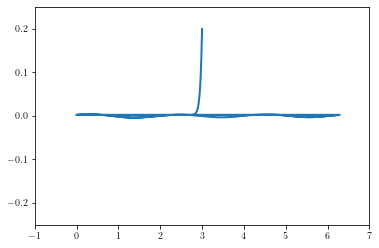

In [165]:
dt23 = .02;T23=2000
t23 = np.arange(0,T23,dt23)

plt = pl_exist(eps23,del23,a23,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t23[0],t23[-1]],[3,.2],t_eval=t23,args=(a23,eps23,del23),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

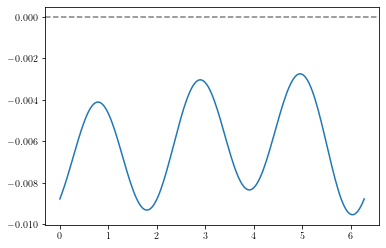

In [166]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = rhs_avg_1d(0,x_temp2,a23,eps23,del23)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

### Integration

In [174]:
init23 = system1.lc['dat'][int((th_init23/(2*np.pi))*system1.TN),:]
args23 = [a23,eps23,del23]
solf23 = solve_ivp(_full,[0,t23[-1]],init23,t_eval=t23,args=(*args23,),**kw_sim)

In [175]:
solr23 = solve_ivp(rhs_avg_2d,[0,t23[-1]],[th_init23,0],t_eval=t23,args=(*args23,),**kw_sim)
# solr23_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args23,1),**kw_sim)

In [176]:
solr23c = solve_ivp(rhs_avg_1d,[0,t23[-1]],[th_init23],t_eval=t23,args=(*args23,),**kw_sim)

In [177]:
# fig,axs = plt.subplots(figsize=(15,2))
# axs.plot(t,solf23.y.T[:,0])

# axs.plot(t,a23.system1.forcing_fn(t*(a23._m[1]+del23)))
# axs.set_xlim(t[-1]-200,t[-1])

In [178]:
tp23, phase23 = get_phase(t23,solf23.y.T,skipn=10,system1=system1)

(0.0, 6.283185307179586)

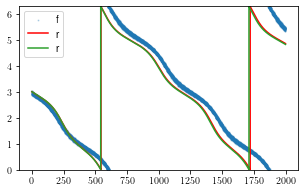

In [179]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase23 = np.mod((a23._m[1]+del23)*np.linspace(0,tp23[-1],len(tp23)),2*np.pi*a23._m[1])
y23 = np.mod(phase23-a23.om*forcing_phase23,2*np.pi)

# axs[0].plot(phase23)
# axs[0].plot(forcing_phase23*a23.om)
axs[0].scatter(tp23,y23,s=1,alpha=.25,label='f')
axs[0].plot(solr23.t,np.mod(solr23.y.T[:,0],2*np.pi),color='r',label='r')
axs[0].plot(solr23c.t,np.mod(solr23c.y.T[:,0],2*np.pi),color='tab:green',label='r')

#axs[0].set_xlim(0,100)

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

# Tongue 1:3

In [152]:
a13 = nmc(system1,None,
        recompute_list=['p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',1),_m=('om1',3),
        NP=500,NH=500)

e1,e2
psi**4*zv0_4(t) + psi**3*zv0_3(t) + psi**2*zv0_2(t) + psi*zv0_1(t) + zv0_0(t)
psi**4*iv0_4(t) + psi**3*iv0_3(t) + psi**2*iv0_2(t) + psi*iv0_1(t) + iv0_0(t)

0 imp0 for z zv0_0(th0)
0 imp0 for i iv0_0(th0)
1 imp0 for z zv0_1(th0)
1 imp0 for i iv0_1(th0)
2 imp0 for z zv0_2(th0)
2 imp0 for i iv0_2(th0)
3 imp0 for z zv0_3(th0)
3 imp0 for i iv0_3(th0)
4 imp0 for z zv0_4(th0)
4 imp0 for i iv0_4(th0)

hz0,hi0,imp
0 uf(t)*zv0_0(t/3 + th0)
1 uf(t)*zv0_1(t/3 + th0)
2 uf(t)*zv0_2(t/3 + th0)
3 uf(t)*zv0_3(t/3 + th0)
4 uf(t)*zv0_4(t/3 + th0)

0 iv0_0(t/3 + th0)*uf(t)
1 iv0_1(t/3 + th0)*uf(t)
2 iv0_2(t/3 + th0)*uf(t)
3 iv0_3(t/3 + th0)*uf(t)
4 iv0_4(t/3 + th0)*uf(t)

* Computing p...
* Computing H thalf0, order=0...
* Computing p...
* Computing H thalf0, order=1...
* Computing p...
* Computing H thalf0, order=2...
* Computing p...
* Computing H thalf0, order=3...
* Computing p...
* Computing H thalf0, order=4...


## Tongue

In [153]:
d1 = np.linspace(-9,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_13a,ve_list_13a = get_tongue_2d(2**d1,a13,deps=.01,max_eps=.2)
del_list_13b,ve_list_13b = get_tongue_2d(-2**d1,a13,deps=.01,max_eps=.2)

1.0     
1.0     


In [154]:
d1 = np.linspace(-10,0,50,endpoint=False)
d13a_ld,v13a_ld = get_tongue_ld(2**d1,a13,deps=.01,max_eps=.4)
d13b_ld,v13b_ld = get_tongue_ld(-2**d1,a13,deps=.01,max_eps=.4)

1.0      
1.0      


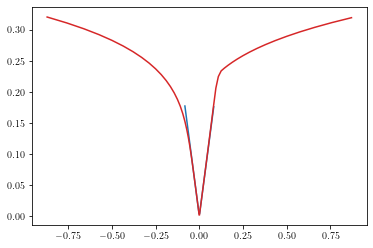

In [155]:
fig,axs = plt.subplots()
axs.plot(del_list_13a,ve_list_13a,color='tab:blue')
axs.plot(del_list_13b,ve_list_13b,color='tab:blue')

axs.plot(d13a_ld,v13a_ld,color='tab:red')
axs.plot(d13b_ld,v13b_ld,color='tab:red')

## Frequency ratio

In [157]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val13 = .035

del_range13 = np.linspace(-.1,.1,30)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

In [159]:
fr_full13 = []
fr_redu13 = []
fr_redu13b = []
fr_redu13c = []

for i in range(len(del_range13)):
    
    args13 = [a13,eps_val13,del_range13[i]]
    
    solf13 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args13,),**kw_sim)
    solr13a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],args=(*args13,),t_eval=t,**kw_sim)
    # solr13b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args13,),**kw_sim)
    #solr13_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args13,1),**kw_sim)
    solr13c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init],args=(*args13,),t_eval=t,**kw_sim)

    timef = t*(a13._m[1]+del_range13[i])
    timer = t*a13._n[1]*(1+del_range13[i]/a13._m[1])
    freq_force = freq_est(t,a13.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf13.y.T[:,0],prominence=.15)
    freq_redu = freq_est(t,np.mod(solr13a.y.T[:,0]+timer,2*np.pi))
    # freq_redub = freq_est(t,np.mod(solr13b.y.T[:,0],2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr13c.y.T[:,0]+timer,2*np.pi))

    print(del_range13[i],freq_full/freq_force,freq_redu/freq_force,freq_reduc/freq_force)

    # fig,axs = plt.subplots()
    # axs.plot(t,solf13.y.T[:,0])
    # axs.plot(t,np.mod(solr13a.y.T[:,0]+timer,2*np.pi))
    # axs.plot(t,a13.system2(timef))
    # axs.set_xlim(t[-1]-50,t[-1])
    # axs.scatter(t[idxs],solf13.y.T[idxs,0])
    # plt.show()

    fr_full13.append(freq_full/freq_force)
    fr_redu13.append(freq_redu/freq_force)
    # fr_redu13b.append(freq_redu/freq_force)
    fr_redu13c.append(freq_reduc/freq_force)

fr_full13 = np.asarray(fr_full13)
fr_redu13 = np.asarray(fr_redu13)
# fr_redu13b = np.asarray(fr_redu13b)
fr_redu13c = np.asarray(fr_redu13c)

-0.1 0.34484151698704896 0.34477205550714424 0.34468179740730953
-0.09310344827586207 0.3440041553017762 0.3438933069011473 0.34379637313500777
-0.08620689655172414 0.34316943464808086 0.3431210493268623 0.3430726776479384
-0.07931034482758621 0.3423013101757891 0.34225994862385967 0.34219792503458746
-0.07241379310344828 0.34160121051615067 0.34155992108699873 0.34149112754800853
-0.06551724137931034 0.34070928687568713 0.3406818385433776 0.34059952007565464
-0.05862068965517241 0.3400327425203161 0.3398957678612011 0.33975890351206534
-0.05172413793103448 0.33907552118298917 0.3389458190448708 0.3388503125244597
-0.04482758620689655 0.33822547642245193 0.3380893175382015 0.33798046933648684
-0.03793103448275862 0.337340971634775 0.3373205999830397 0.3373002307915993
-0.031034482758620682 0.3363731201635588 0.33637312016355875 0.336352818401991
-0.02413793103448275 0.3358241093743815 0.3355403714425021 0.33530428916286625
-0.01724137931034482 0.3346246023947823 0.33449680606421933 0.3

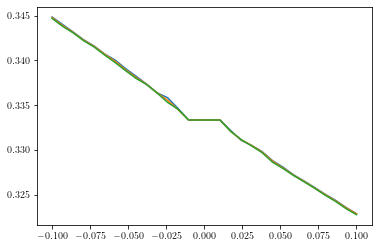

In [160]:
fig,axs = plt.subplots()
axs.plot(del_range13,fr_full13)
axs.plot(del_range13,fr_redu13)
# axs.plot(del_range13,fr_redu13b)
axs.plot(del_range13,fr_redu13c)

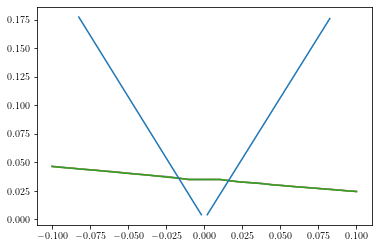

In [161]:
fig,axs = plt.subplots()
axs.plot(del_range13,fr_full13-1/3+eps_val13)
axs.plot(del_range13,fr_redu13-1/3+eps_val13)
# axs.plot(del_range13,fr_redu13b-1/3+eps_val13)
axs.plot(del_range13,fr_redu13c-1/3+eps_val13)

axs.plot(del_list_13a,ve_list_13a,color='tab:blue')
axs.plot(del_list_13b,ve_list_13b,color='tab:blue')

## Verify

In [182]:
eps13 = .035
del13 = -0.01
th_init13 = 3

### Phase plane

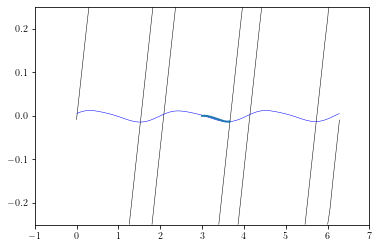

In [183]:
dt13 = .02;T13=2000
t13 = np.arange(0,T13,dt13)

plt = pl_exist(eps13,del13,a13,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t13[0],t13[-1]],[th_init13,0],t_eval=t13,args=(a13,eps13,del13),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

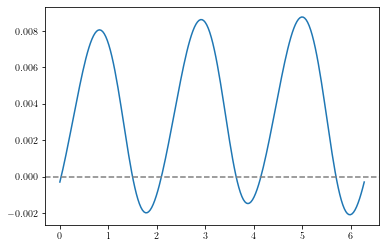

In [184]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = rhs_avg_1d(0,x_temp2,a13,eps13,del13)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

### Integration

In [185]:
init13 = system1.lc['dat'][int((th_init13/(2*np.pi))*system1.TN),:]
args13 = [a13,eps13,del13]
solf13 = solve_ivp(_full,[0,t13[-1]],init13,t_eval=t13,args=(*args13,),**kw_sim)

In [186]:
solr13 = solve_ivp(rhs_avg_2d,[0,t13[-1]],[th_init13,0],t_eval=t13,args=(*args13,),**kw_sim)
# solr13_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args13,1),**kw_sim)

In [187]:
# solr13b = solve_ivp(_redu,[0,t13[-1]],[th_init13,0,0],t_eval=t13,args=(*args13,),**kw_sim)

In [188]:
solr13c = solve_ivp(rhs_avg_1d,[0,t13[-1]],[th_init13],t_eval=t13,args=(*args13,),**kw_sim)

In [189]:
tp13, phase13 = get_phase(t13,solf13.y.T,skipn=100,system1=system1)

(0.0, 6.283185307179586)

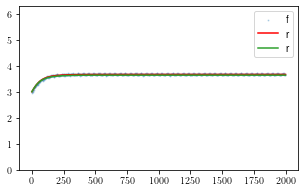

In [190]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase13 = np.mod((a13._m[1]+del13)*np.linspace(0,tp13[-1],len(tp13)),2*np.pi*a13._m[1])
y13 = np.mod(phase13-a13.om*forcing_phase13,2*np.pi)

#axs[0].plot(phase13)
axs[0].scatter(tp13,y13,s=1,alpha=.25,label='f')
axs[0].plot(solr13.t,np.mod(solr13.y.T[:,0],2*np.pi),color='r',label='r')
# axs[0].plot(solr13b.t,np.mod(solr13b.y.T[:,0]-a13.om*solr13b.y.T[:,2],2*np.pi),color='green',label='r f',alpha=.5)
axs[0].plot(solr13c.t,np.mod(solr13c.y.T[:,0],2*np.pi),color='tab:green',label='r')

#axs[0].set_xlim(0,100)

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

# 3:2 DNE?

In [191]:
a32 = nmc(system1,None,
        recompute_list=['p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',3),_m=('om1',2),
        NP=500,NH=500)

e1,e2
psi**4*zv0_4(t) + psi**3*zv0_3(t) + psi**2*zv0_2(t) + psi*zv0_1(t) + zv0_0(t)
psi**4*iv0_4(t) + psi**3*iv0_3(t) + psi**2*iv0_2(t) + psi*iv0_1(t) + iv0_0(t)

0 imp0 for z zv0_0(th0)
0 imp0 for i iv0_0(th0)
1 imp0 for z zv0_1(th0)
1 imp0 for i iv0_1(th0)
2 imp0 for z zv0_2(th0)
2 imp0 for i iv0_2(th0)
3 imp0 for z zv0_3(th0)
3 imp0 for i iv0_3(th0)
4 imp0 for z zv0_4(th0)
4 imp0 for i iv0_4(th0)

hz0,hi0,imp
0 uf(t)*zv0_0(3*t/2 + th0)
1 uf(t)*zv0_1(3*t/2 + th0)
2 uf(t)*zv0_2(3*t/2 + th0)
3 uf(t)*zv0_3(3*t/2 + th0)
4 uf(t)*zv0_4(3*t/2 + th0)

0 iv0_0(3*t/2 + th0)*uf(t)
1 iv0_1(3*t/2 + th0)*uf(t)
2 iv0_2(3*t/2 + th0)*uf(t)
3 iv0_3(3*t/2 + th0)*uf(t)
4 iv0_4(3*t/2 + th0)*uf(t)

* Computing p...
* Computing H thalf0, order=0...
* Computing p...
* Computing H thalf0, order=1...
* Computing p...
* Computing H thalf0, order=2...
* Computing p...
* Computing H thalf0, order=3...
* Computing p...
* Computing H thalf0, order=4...


## Tongue

In [192]:
d1 = np.linspace(-15,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_32a,ve_list_32a = get_tongue_2d(2**d1,a32,deps=.01,max_eps=.2)
del_list_32b,ve_list_32b = get_tongue_2d(-2**d1,a32,deps=.01,max_eps=.2)

1.0     
1.0     


In [193]:
d1 = np.linspace(-10,0,50,endpoint=False)
d32a_ld,v32a_ld = get_tongue_ld(2**d1,a32,deps=.01,max_eps=.4)
d32b_ld,v32b_ld = get_tongue_ld(-2**d1,a32,deps=.01,max_eps=.4)

1.0      
1.0      


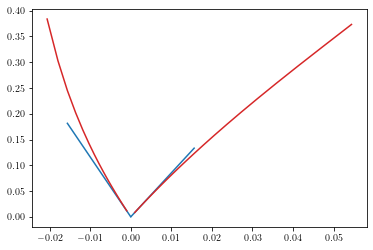

In [194]:
fig,axs = plt.subplots()
axs.plot(del_list_32a,ve_list_32a,color='tab:blue')
axs.plot(del_list_32b,ve_list_32b,color='tab:blue')

axs.plot(d32a_ld,v32a_ld,color='tab:red')
axs.plot(d32b_ld,v32b_ld,color='tab:red')

## Frequency ratio

In [195]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val32 = .03

del_range32 = np.linspace(-.01,.01,15)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

In [196]:
fr_full32 = []
fr_redu32 = []
fr_redu32b = []
fr_redu32c = []

for i in range(len(del_range32)):
    
    args32 = [a32,eps_val32,del_range32[i]]
    
    solf32 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args32,),**kw_sim)
    solr32a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],args=(*args32,),t_eval=t,**kw_sim)
    # solr32b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args32,),**kw_sim)
    #solr32_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args32,1),**kw_sim)
    solr32c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init],args=(*args32,),t_eval=t,**kw_sim)

    timef = t*(a32._m[1]+del_range32[i])
    timer = t*a32._n[1]*(1+del_range32[i]/a32._m[1])
    
    freq_force = freq_est(t,a32.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf32.y.T[:,0],prominence=.2,width=10)
    freq_redu = freq_est(t,np.mod(solr32a.y.T[:,0]+timer,2*np.pi))
    # freq_redub = freq_est(t,np.mod(solr32b.y.T[:,0],2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr32c.y.T[:,0]+timer,2*np.pi))

    print(del_range32[i],freq_full/freq_force,freq_redu/freq_force,freq_reduc/freq_force)

    # fig,axs = plt.subplots(1,2)
    # axs[0].plot(t,solf32.y.T[:,0])
    # axs.plot(t,np.mod(solr32a.y.T[:,0]+timer,2*np.pi))
    # axs.plot(t,a32.system1.forcing_fn(timef))
    # axs[0].set_xlim(t[-1]-50,t[-1])
    # axs[0].scatter(t[idxs],solf32.y.T[idxs,0])
    # plt.show()

    fr_full32.append(freq_full/freq_force)
    fr_redu32.append(freq_redu/freq_force)
    fr_redu32c.append(freq_reduc/freq_force)
    # fr_redu32b.append(freq_redu/freq_force)

fr_full32 = np.asarray(fr_full32)
fr_redu32 = np.asarray(fr_redu32)
fr_redu32c = np.asarray(fr_redu32c)
# fr_redu32b = np.asarray(fr_redu32b)

-0.01 1.499601368341779 1.5079535073898411 1.5079837681360964
-0.008571428571428572 1.4996545311222813 1.5065562516835969 1.5065864777183797
-0.0071428571428571435 1.4979251864325236 1.5052715107347359 1.505301707358755
-0.005714285714285714 1.4972028953541996 1.5047270541837585 1.504878046302064
-0.004285714285714286 1.4962100703844068 1.5026437203233538 1.5027944066170087
-0.0028571428571428576 1.4942883482303897 1.501556322843956 1.5014358852002547
-0.0014285714285714284 1.493176352705411 1.5000779084993863 1.5001079828374542
0.0 1.4924233313289232 1.5000133319349613 1.5000133319349613
0.0014285714285714284 1.491280992563789 1.4999484136301866 1.4999785264248227
0.0028571428571428567 1.4901390948811484 1.4997932758981056 1.4998234037234992
0.004285714285714285 1.489206253758268 1.4975910747043786 1.4975309570425144
0.005714285714285715 1.488324989447216 1.4969755631869957 1.4970356790660866
0.0071428571428571435 1.4873983719847315 1.4952331292687797 1.4953831867864693
0.008571428571

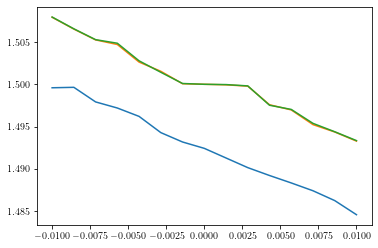

In [204]:
fig,axs = plt.subplots()
axs.plot(del_range32,fr_full32)
axs.plot(del_range32,fr_redu32)
# axs.plot(del_range32,fr_redu32b)
axs.plot(del_range32,fr_redu32c)

## Verify

In [209]:
eps32 = .02
del32 = 0.002
th_init32 = 3

### Phase plane

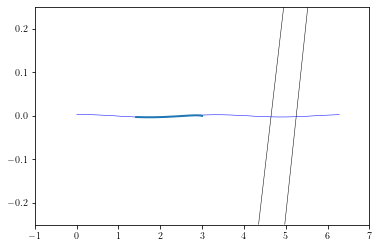

In [210]:
dt32 = .02;T32=2000
t32 = np.arange(0,T32,dt32)

plt = pl_exist(eps32,del32,a32,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t32[0],t32[-1]],[th_init32,0],t_eval=t32,args=(a32,eps32,del32),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

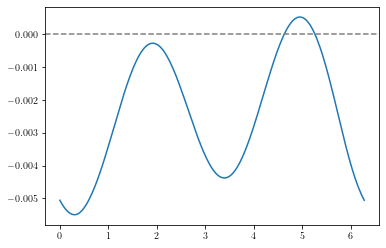

In [211]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = rhs_avg_1d(0,x_temp2,a32,eps32,del32)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

### Integration

In [200]:
init32 = system1.lc['dat'][int((th_init32/(2*np.pi))*system1.TN),:]
args32 = [a32,eps32,del32]
solf32 = solve_ivp(_full,[0,t32[-1]],init32,t_eval=t32,args=(*args32,),**kw_sim)

In [201]:
solr32 = solve_ivp(rhs_avg_2d,[0,t32[-1]],[th_init32,0],t_eval=t32,args=(*args32,),**kw_sim)
# solr32_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args32,1),**kw_sim)

In [532]:
# solr32b = solve_ivp(_redu,[0,t32[-1]],[th_init32,0,0],t_eval=t32,args=(*args32,),**kw_sim)

In [202]:
solr32c = solve_ivp(rhs_avg_1d,[0,t32[-1]],[th_init32],t_eval=t32,args=(*args32,),**kw_sim)

In [203]:
tp32, phase32 = get_phase(t32,solf32.y.T,skipn=10,system1=system1)

(0.0, 6.283185307179586)

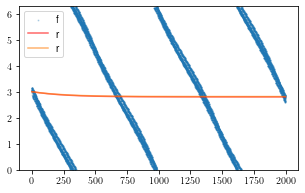

In [212]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase32 = np.mod((a32._m[1]+del32)*np.linspace(0,tp32[-1],len(tp32)),2*np.pi*a32._m[1])
y32 = np.mod(phase32-a32.om*forcing_phase32,2*np.pi)

axs[0].scatter(tp32,y32,s=1,alpha=.25,label='f')
axs[0].plot(solr32.t,np.mod(solr32.y.T[:,0],2*np.pi),color='r',label='r',alpha=.6)
axs[0].plot(solr32c.t,np.mod(solr32c.y.T[:,0],2*np.pi),color='tab:orange',label='r',alpha=.6)
# axs[0].plot(solr32b.t,np.mod(solr32b.y.T[:,0]-a32.om*solr32b.y.T[:,2],2*np.pi),color='green',label='rf',alpha=.6)

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

# 2:1

In [213]:
a21 = nmc(system1,None,
        recompute_list=['p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',2),_m=('om1',1),
        NP=500,NH=500)

e1,e2
psi**4*zv0_4(t) + psi**3*zv0_3(t) + psi**2*zv0_2(t) + psi*zv0_1(t) + zv0_0(t)
psi**4*iv0_4(t) + psi**3*iv0_3(t) + psi**2*iv0_2(t) + psi*iv0_1(t) + iv0_0(t)

0 imp0 for z zv0_0(th0)
0 imp0 for i iv0_0(th0)
1 imp0 for z zv0_1(th0)
1 imp0 for i iv0_1(th0)
2 imp0 for z zv0_2(th0)
2 imp0 for i iv0_2(th0)
3 imp0 for z zv0_3(th0)
3 imp0 for i iv0_3(th0)
4 imp0 for z zv0_4(th0)
4 imp0 for i iv0_4(th0)

hz0,hi0,imp
0 uf(t)*zv0_0(2*t + th0)
1 uf(t)*zv0_1(2*t + th0)
2 uf(t)*zv0_2(2*t + th0)
3 uf(t)*zv0_3(2*t + th0)
4 uf(t)*zv0_4(2*t + th0)

0 iv0_0(2*t + th0)*uf(t)
1 iv0_1(2*t + th0)*uf(t)
2 iv0_2(2*t + th0)*uf(t)
3 iv0_3(2*t + th0)*uf(t)
4 iv0_4(2*t + th0)*uf(t)

* Computing p...
* Computing H thalf0, order=0...
* Computing p...
* Computing H thalf0, order=1...
* Computing p...
* Computing H thalf0, order=2...
* Computing p...
* Computing H thalf0, order=3...
* Computing p...
* Computing H thalf0, order=4...


## Tongue

In [216]:
d1 = np.linspace(-10,-1,10)
del_list_21a,ve_list_21a = get_tongue_2d(2**d1,a21,deps=.01,max_eps=.3)
del_list_21b,ve_list_21b = get_tongue_2d(-2**d1,a21,deps=.01,max_eps=.3)

1.0     
1.0     


In [214]:
d1 = np.linspace(-10,0,50,endpoint=False)
d21a_ld,v21a_ld = get_tongue_ld(2**d1,a21,deps=.01,max_eps=.4)
d21b_ld,v21b_ld = get_tongue_ld(-2**d1,a21,deps=.01,max_eps=.4)

1.0      
1.0      


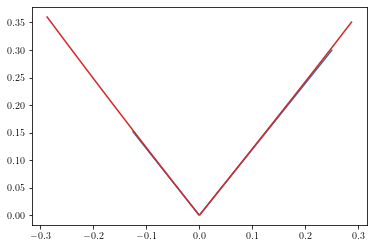

In [217]:
fig,axs = plt.subplots()
axs.plot(del_list_21a,ve_list_21a,color='tab:blue')
axs.plot(del_list_21b,ve_list_21b,color='tab:blue')

axs.plot(d21a_ld,v21a_ld,color='tab:red')
axs.plot(d21b_ld,v21b_ld,color='tab:red')

## Frequency ratio

In [225]:
# fix eps.
# x-axis, deviation from baseline freq. this is delta
# y-axis, ratio of oscillator vs forcing fn frequency
eps_val21 = .025

del_range21 = np.linspace(-.1,.1,10)

th_init = 3

dt = .01;T=1000
t = np.arange(0,T,dt)

y0 = system1.lc['dat'][int((th_init/(2*np.pi))*system1.TN),:]

fr_full21 = []
fr_redu21 = []
fr_redu21b = []
fr_redu21c = []

for i in range(len(del_range21)):
    
    args21 = [a21,eps_val21,del_range21[i]]
    
    solf21 = solve_ivp(_full,[0,t[-1]],y0,t_eval=t,args=(*args21,),**kw_sim)
    solr21a = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,),**kw_sim)
    # solr21b = solve_ivp(_redu,[0,t[-1]],[th_init,0,0],t_eval=t,args=(*args21,),**kw_sim)
    #solr21_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,1),**kw_sim)
    solr21c = solve_ivp(rhs_avg_1d,[0,t[-1]],[th_init],t_eval=t,args=(*args21,),**kw_sim)

    timef = t*(a21._m[1]+del_range21[i])
    timer = t*(a21._n[1]+a21._n[1]*del_range21[i]/a21._m[1])
    freq_force = freq_est(t,a21.system1.forcing_fn(timef))
    freq_full = freq_est(t,solf21.y.T[:,0])
    freq_redu = freq_est(t,np.mod(solr21a.y.T[:,0]+timer,2*np.pi))
    # freq_redub = freq_est(t,np.mod(solr21b.y.T[:,0],2*np.pi))
    freq_reduc = freq_est(t,np.mod(solr21c.y.T[:,0]+timer,2*np.pi))

    # fig,axs = plt.subplots()
    # axs.plot(t,21*np.mod(solf21.y.T[:,0],2*np.pi)-70)
    # axs.plot(t,np.mod(solr21a.y.T[:,0],2*np.pi))
    # axs.plot(t,21*a21.system2(t*(a21._m[1]+del_range21[i])))
    # axs.set_xlim(t[-1]-200,t[-1])
    # plt.show()

    print(del_range21[i],freq_full/freq_force,freq_redu/freq_force,freq_reduc/freq_force)

    fr_full21.append(freq_full/freq_force)
    fr_redu21.append(freq_redu/freq_force)
    # fr_redu21b.append(freq_redub/freq_force)
    fr_redu21c.append(freq_reduc/freq_force)

fr_full21 = np.asarray(fr_full21)
fr_redu21 = np.asarray(fr_redu21)
# fr_redu21b = np.asarray(fr_redu21b)
fr_redu21c = np.asarray(fr_redu21c)

-0.1 2.213118524961413 2.2183258626672044 2.218816701957733
-0.07777777777777778 2.1579005471609722 2.163092088370899 2.1632659668772285
-0.05555555555555556 2.1048617385900505 2.1096806389932334 2.1097653260108356
-0.03333333333333334 2.0512559892766955 2.054477143816841 2.0544771438168414
-0.011111111111111113 2.0003884692255762 1.9999874049135236 1.9999473073273148
0.011111111111111113 1.9999358355107673 1.9999760651455813 1.9999760651455813
0.033333333333333326 1.9392207772911818 1.9485249300920888 1.9492667047599264
0.05555555555555555 1.8931535639528665 1.9019578979072918 1.902454901920896
0.07777777777777778 1.8544076493918213 1.8608620176569781 1.8611235583481454
0.1 1.815288325023079 1.823220310589877 1.823476550519488


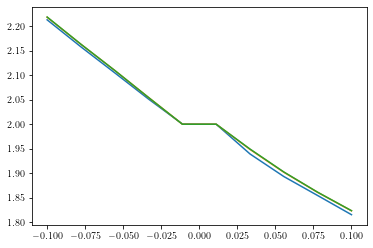

In [226]:
fig,axs = plt.subplots()
axs.plot(del_range21,fr_full21)
axs.plot(del_range21,fr_redu21)
# axs.plot(del_range21,fr_redu21b)
axs.plot(del_range21,fr_redu21c)

In [228]:
# fig,axs = plt.subplots()
# axs.plot(del_range21,fr_full21-2+eps_val21)
# axs.plot(del_range21,fr_redu21-2+eps_val21)
# # axs.plot(del_range21,fr_redu21b-2+eps_val21)

# axs.plot(del_list_21a,ve_list_21a,color='tab:blue')
# axs.plot(del_list_21b,ve_list_21b,color='tab:blue')

## Verify

In [229]:
eps21 = .05
del21 = -.01
th_init21 = 3

### Phase plane

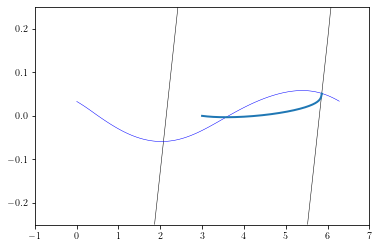

In [230]:
dt21 = .02;T21=2000
t21 = np.arange(0,T21,dt21)

plt = pl_exist(eps21,del21,a21,return_data=True)

out1 = solve_ivp(rhs_avg_2d,[t21[0],t21[-1]],[th_init21,0],t_eval=t21,args=(a21,eps21,del21),**kw_sim)
plt.plot(np.mod(out1.y.T[:,0],2*np.pi),out1.y.T[:,1],lw=2)

plt.xlim(-1,7)

plt.show()

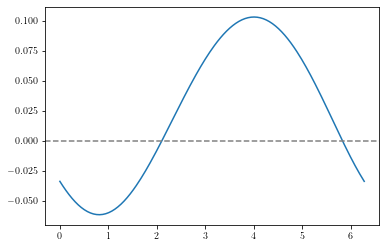

In [231]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = rhs_avg_1d(0,x_temp2,a21,eps21,del21)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

### Integration

In [232]:
init21 = system1.lc['dat'][int((th_init21/(2*np.pi))*system1.TN),:]
args21 = [a21,eps21,del21]
solf21 = solve_ivp(_full,[0,t21[-1]],init21,t_eval=t21,args=(*args21,),**kw_sim)

In [233]:
solr21 = solve_ivp(rhs_avg_2d,[0,t21[-1]],[th_init21,0],t_eval=t21,args=(*args21,),**kw_sim)
# solr21_0 = solve_ivp(rhs_avg_2d,[0,t[-1]],[th_init,0],t_eval=t,args=(*args21,1),**kw_sim)

In [234]:
solr21c = solve_ivp(rhs_avg_1d,[0,t21[-1]],[th_init21],t_eval=t21,args=(*args21,),**kw_sim)

In [235]:
tp21, phase21 = get_phase(t21,solf21.y.T,skipn=10,system1=system1)

(0.0, 6.283185307179586)

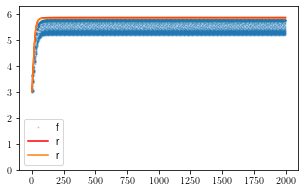

In [236]:
fig,axs = plt.subplots(figsize=(5,3)); axs = np.asarray([axs])
forcing_phase21 = np.mod((a21._m[1]+del21)*np.linspace(0,tp21[-1],len(tp21)),2*np.pi*a21._m[1])
y21 = np.mod(phase21-a21.om*forcing_phase21,2*np.pi)

axs[0].scatter(tp21,y21,s=1,alpha=.25,label='f')
axs[0].plot(solr21.t,np.mod(solr21.y.T[:,0],2*np.pi),color='r',label='r')
axs[0].plot(solr21c.t,np.mod(solr21c.y.T[:,0],2*np.pi),color='tab:orange',label='r')

axs[0].legend()
axs[0].set_ylim(0,2*np.pi)

# Plot all tongues

In [237]:
import matplotlib

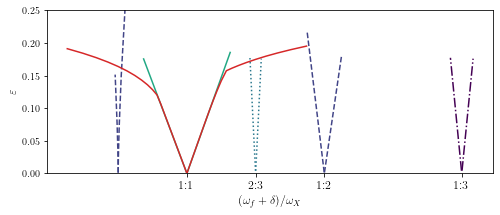

In [240]:
cmap = matplotlib.colormaps['viridis']
fsize = 12

fig,axs = plt.subplots(figsize=(8,3))

axs.plot((del_list_13a+3)/1,ve_list_13a,color=cmap(0),label='1:3',ls='-.')
axs.plot((del_list_13b+3)/1,ve_list_13b,color=cmap(0),ls='-.')

axs.plot((del_list_12a+2)/1,ve_list_12a,color=cmap(.2),label='1:2',ls='--')
axs.plot((del_list_12b+2)/1,ve_list_12b,color=cmap(.2),ls='--')

axs.plot((del_list_32a+1)/2,ve_list_21a,color=cmap(.2),label='1:2',ls='--')
axs.plot((del_list_32b+1)/2,ve_list_21b,color=cmap(.2),ls='--')

axs.plot((del_list_13a+3)/2,ve_list_13a,color=cmap(.4),label='2:3',ls=':')
axs.plot((del_list_13b+3)/2,ve_list_13b,color=cmap(.4),ls=':')

axs.plot(del_list_11a+1,ve_list_11a,label='1:1',color=cmap(.6))
axs.plot(del_list_11b+1,ve_list_11b,label='1:1',color=cmap(.6))

axs.plot(d11a_ld+1,v11a_ld,color='tab:red')
axs.plot(d11b_ld+1,v11b_ld,color='tab:red')

# axs.plot((del_list_23a+2)/3,ve_list_23a,color=cmap(.8),label='2:3',ls=':')
# axs.plot((del_list_23b+2)/3,ve_list_23b,color=cmap(.8),ls=':')

axs.set_ylim(0,.25)

#axs.set_yscale('log')
axs.set_xlabel(r'$(\omega_f+\delta)/\omega_X$',fontsize=fsize)
axs.set_ylabel(r'$\varepsilon$',fontsize=fsize)

axs.set_xticks([3,2,3/2,1])
axs.set_xticklabels(['$1{:}3$','$1{:}2$','$2{:}3$','$1{:}1$'],fontsize=fsize)

plt.savefig('../')